# Wrangling Data From Bay Area Bike Share Published Data - Status

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
print('Loading Status Data...')

# glob all files
file_path_slug = '../source_data/*_status_data.csv'
file_list = glob(file_path_slug)

status_df = pd.DataFrame()
chunks = []

file_counter = 1

# load data from each file
for file in file_list:
    file_name = file.split('/')[-1]
    print('\tLoading file\t%s' % file_name)

    chunk_counter = 1
    chunksize = 10000
    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/chunksize)

    # import file in chunks
    for chunk in pd.read_csv(file, chunksize=chunksize, iterator=True):
        
        # correct date time formatting
        if file_name == '201408_status_data.csv' or file_name == '201508_status_data.csv':
            # 2014-03-01 00:00:02
            chunk['time']   = pd.to_datetime(chunk['time'],   format="%Y-%m-%d %H:%M:%S").values.astype('<M8[m]')
            
        if file_name == '201608_status_data.csv':
            # 9/1/2015 00:00:02
            chunk['time']   = pd.to_datetime(chunk['time'],   format="%m/%d/%Y %H:%M:%S").values.astype('<M8[m]')
        
        if file_name == '201402_status_data.csv':
            # 2013/08/29 12:06:01
            chunk['time']   = pd.to_datetime(chunk['time'],   format="%Y/%m/%d %H:%M:%S").values.astype('<M8[m]')
            
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), str(chunk_counter).rjust(5), str(num_chunks).rjust(5)))
        chunk_counter += 1

    print('Finished file! (%d of %d)\n' % (file_counter, len(file_list)))
    file_counter += 1

# print('Merging chunks to dataframes')
status_df = pd.concat(chunks)
print('Data Loaded Successfully!')


Loading Status Data...
	Loading file	201408_status_data.csv
	[16:10:47.639585] finished chunk     1 of  1835
	[16:10:50.825600] finished chunk   184 of  1835
	[16:10:54.117293] finished chunk   368 of  1835
	[16:10:57.349501] finished chunk   552 of  1835
	[16:11:00.604071] finished chunk   736 of  1835
	[16:11:03.852791] finished chunk   920 of  1835
	[16:11:07.683162] finished chunk  1104 of  1835
	[16:11:11.294478] finished chunk  1288 of  1835
	[16:11:14.657108] finished chunk  1472 of  1835
	[16:11:17.967462] finished chunk  1656 of  1835
	[16:11:21.197287] finished chunk  1835 of  1835
Finished file! (1 of 4)

	Loading file	201508_status_data.csv
	[16:11:30.895934] finished chunk     1 of  3665
	[16:11:39.180801] finished chunk   367 of  3665
	[16:11:46.880010] finished chunk   734 of  3665
	[16:11:54.144700] finished chunk  1101 of  3665
	[16:12:02.669432] finished chunk  1468 of  3665
	[16:12:11.857397] finished chunk  1835 of  3665
	[16:12:20.662531] finished chunk  2202 of  3

In [5]:
status_df.head()

,station_id,bikes_available,docks_available,time
0,2,12,15,2014-03-01 00:00:00
1,2,12,15,2014-03-01 00:01:00
2,2,12,15,2014-03-01 00:02:00
3,2,12,15,2014-03-01 00:03:00
4,2,12,15,2014-03-01 00:04:00


In [6]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107501619 entries, 0 to 16994601
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.0 GB


In [7]:
print('[%s] Cleaning up duplicates' % datetime.datetime.now().time())
status_df.drop_duplicates(inplace=True)
print('[%s] Resetting Index' % datetime.datetime.now().time())
status_df.reset_index(drop=True, inplace=True)
print('\t[%s]Complete!\n' % datetime.datetime.now().time())
status_df.head(3)

[16:19:03.748387] Cleaning up duplicates
[16:22:01.141719] Resetting Index
	[16:22:01.264433]Complete!



,station_id,bikes_available,docks_available,time
0,2,12,15,2014-03-01 00:00:00
1,2,12,15,2014-03-01 00:01:00
2,2,12,15,2014-03-01 00:02:00


In [8]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107233299 entries, 0 to 107233298
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.2 GB


# Cleaning Functions

In [12]:
def show_station(df, id, time_min, time_max, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    '''Plot Usage of station between two time stamps
        usage is default the number of 'bikes_available' at any given time period
    '''
    t = pd.DataFrame()
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].plot(color=color, figsize=(24,3))
    ax.set_xlim(time_min, time_max)
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()
    
    # empty out t dataframe, HOpefully more memory concious
    t = pd.DataFrame()

In [13]:
def date_fixes(df=None, old_station=0, new_station=0, change_date=None):
    '''Update status records from old station id to new station id on dates following the change date value '''
    print('[%s]\tUpdating %s to %s for dates after %s' % (datetime.datetime.now().time(), old_station, new_station, change_date))

    print('[%s]\tStarted indexing...' % datetime.datetime.now().time())
    index_to_update = df[(df.station_id == old_station) & (df.time >= change_date)].index
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())    

    station_check = [old_station, new_station]

    t_min = pd.Timestamp('2013-07-01')
    t_max = pd.Timestamp('2016-10-01')

    print('[%s]\tStarted Update...' % datetime.datetime.now().time())
    df.loc[index_to_update, 'station_id'] = new_station
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())

    for station in station_check:
        show_station(df, station, t_min, t_max)
    
    return df

# Correct Relocated Stations
<p>From the notes included with the dataset, there was a delay in the renaming of stations relocated when services in Redwood City was discontinued.</p>
<p>Here we will first look at the incorrect data, and then correct the status's with relocated stations to proper dates.</p>

## 'Old' Stations prior to cleaning

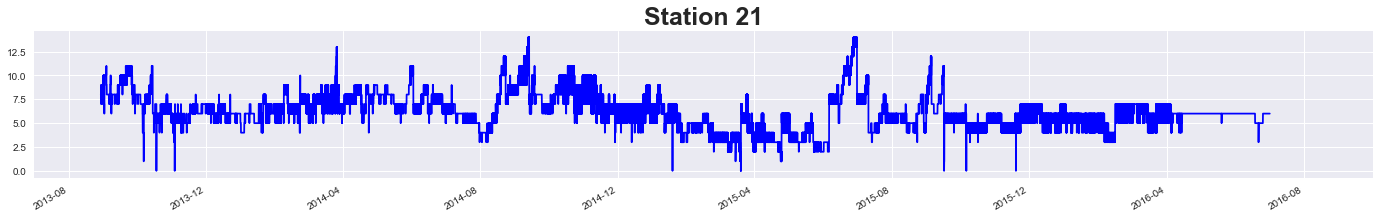

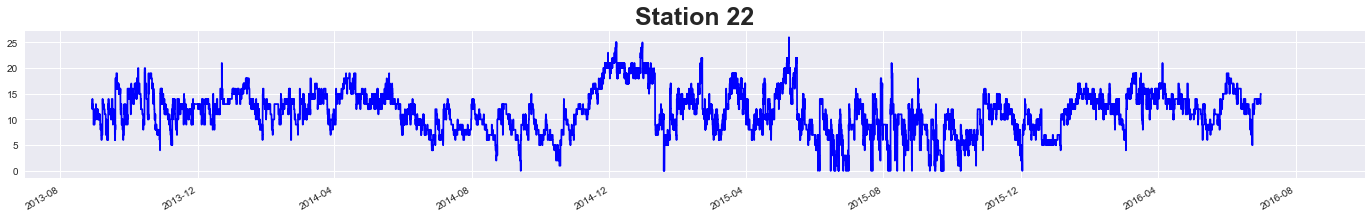

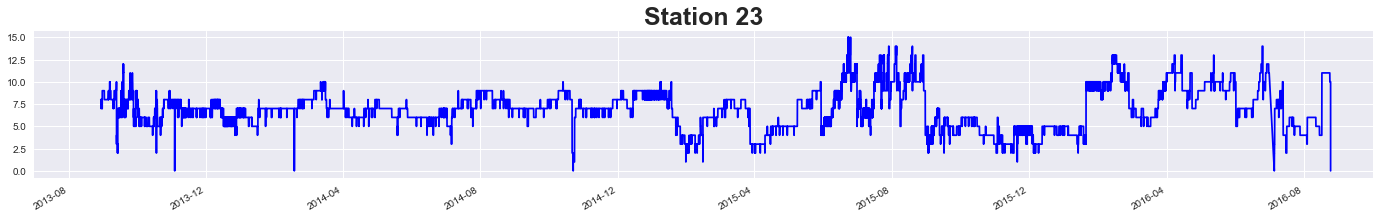

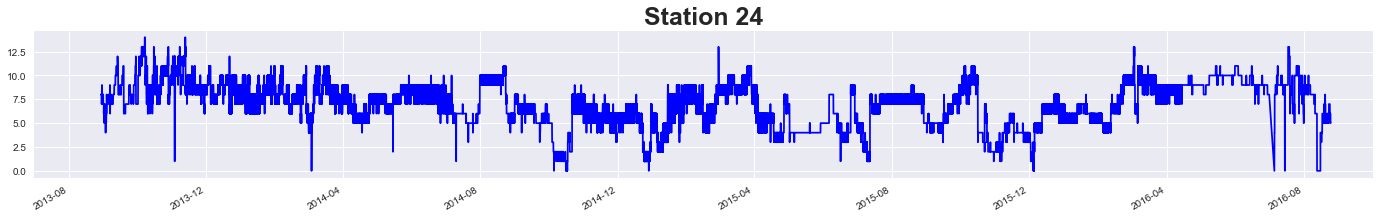

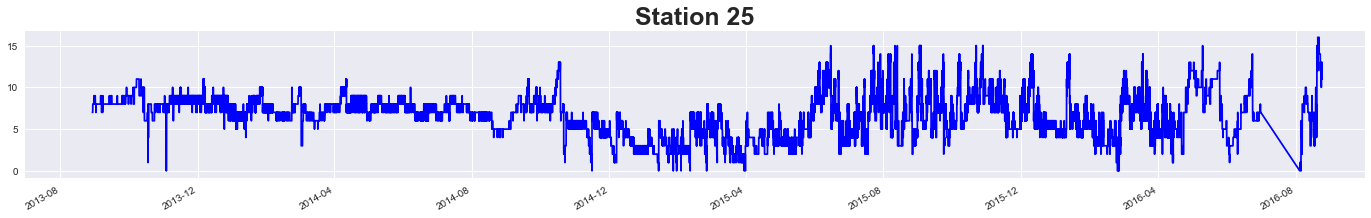

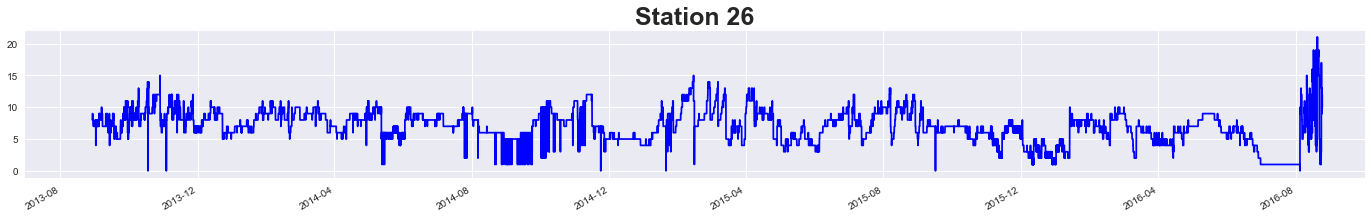

In [14]:
closed_stations = [21, 22, 23, 24, 25, 26]

t_min = pd.Timestamp('2013-07-01')
t_max = pd.Timestamp('2016-10-01')

for station in closed_stations:
    show_station(status_df, station, t_min, t_max)

## 'New' stations prior to cleaning

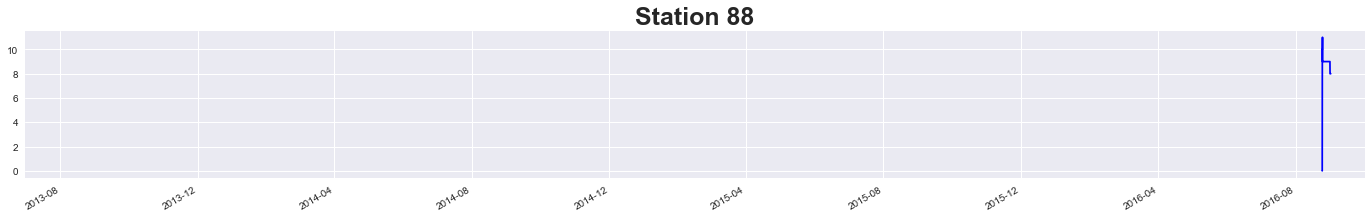

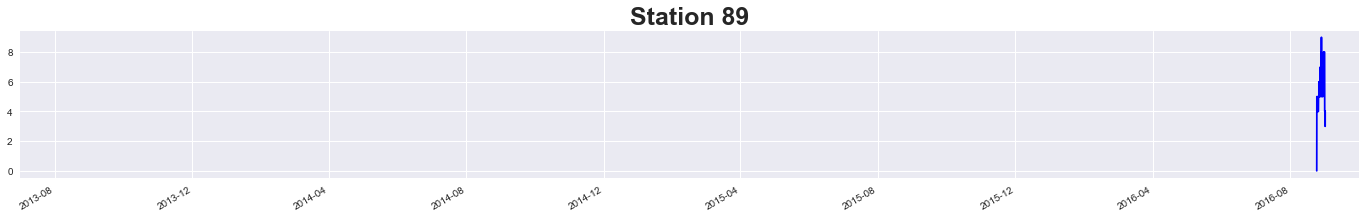

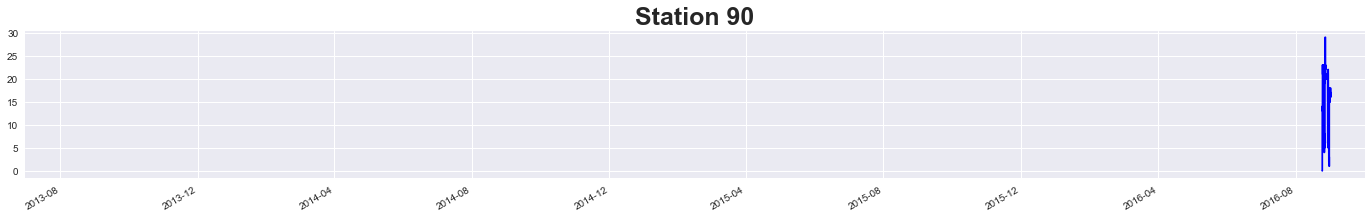

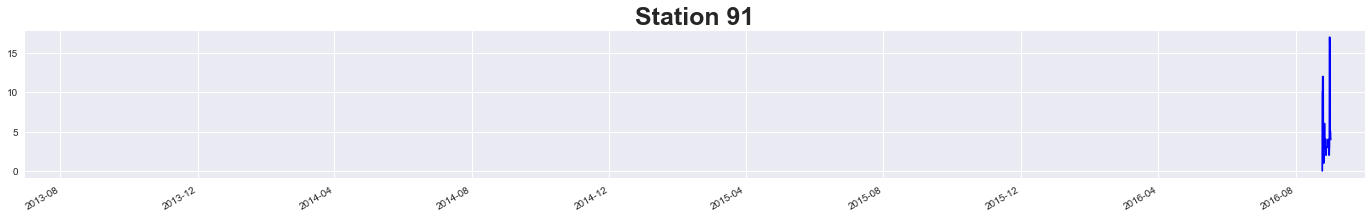

In [15]:
relocated_stations = [88, 89, 90, 91]

for station in relocated_stations:
    show_station(status_df, station, t_min, t_max)

## Correct Stations Dates for Status Records

[16:27:33.273816]	Updating 23 to 88 for dates after 2016-07-05 00:00:00
[16:27:33.274278]	Started indexing...
	[16:27:36.898412]	Complete!
[16:27:36.898767]	Started Update...
	[16:28:59.406348]	Complete!


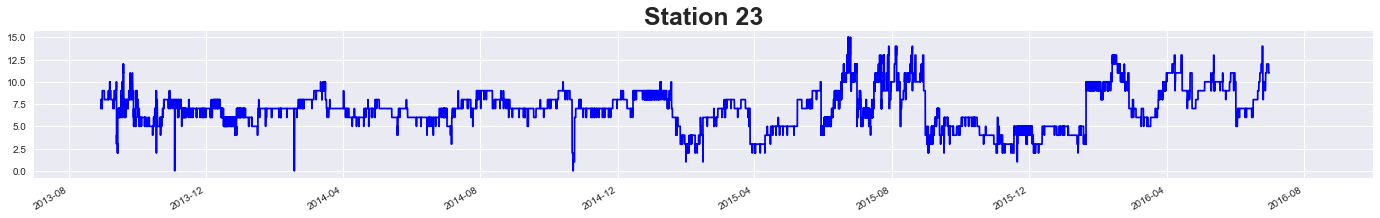

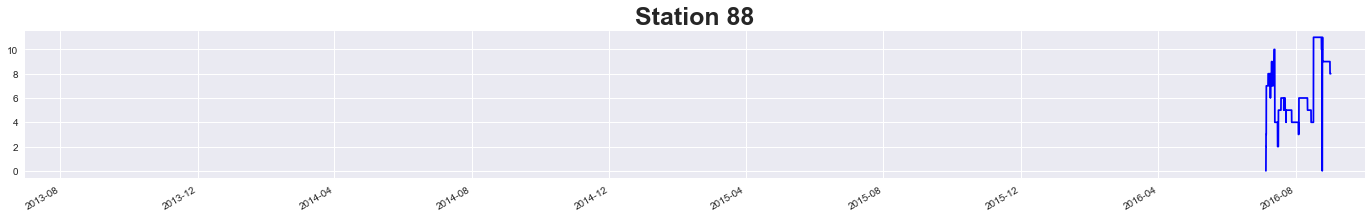

[16:29:27.269452]	Updating 24 to 89 for dates after 2016-07-05 00:00:00
[16:29:27.269598]	Started indexing...
	[16:29:31.494696]	Complete!
[16:29:31.494989]	Started Update...
	[16:29:43.023748]	Complete!


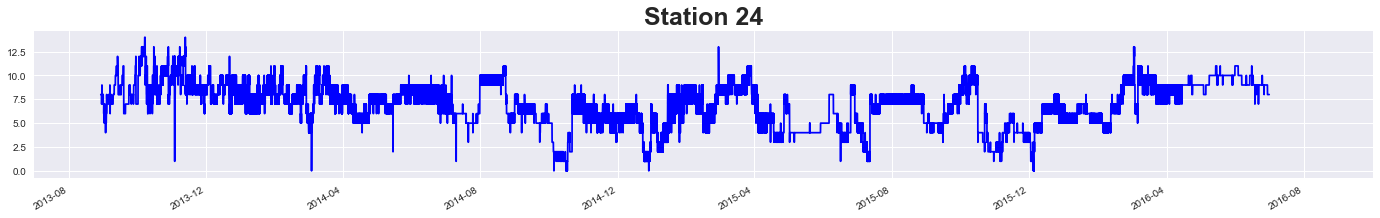

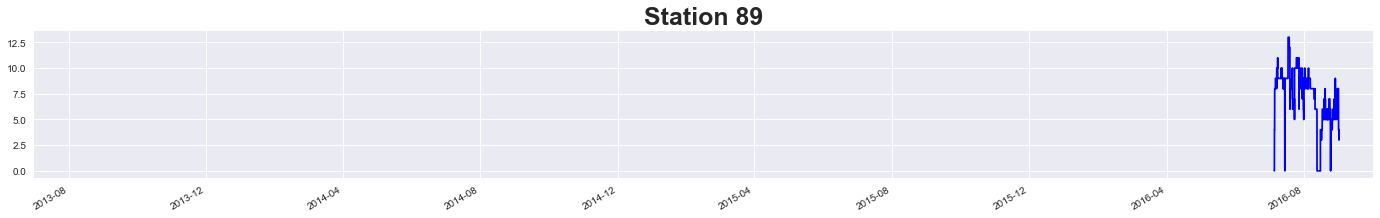

[16:30:13.723014]	Updating 25 to 91 for dates after 2016-08-04 00:00:00
[16:30:13.723142]	Started indexing...
	[16:30:17.423874]	Complete!
[16:30:17.424207]	Started Update...
	[16:30:28.153150]	Complete!


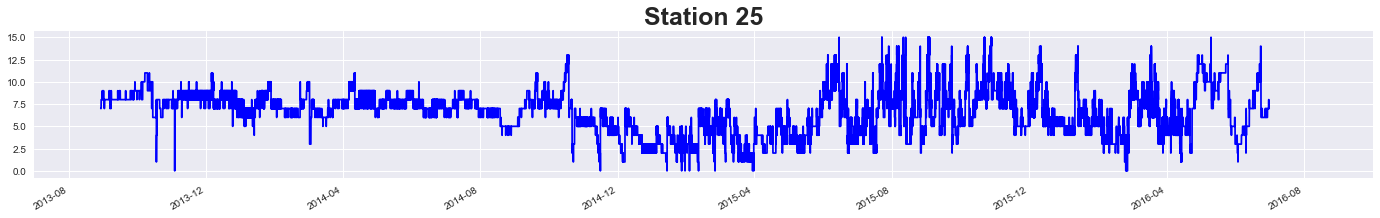

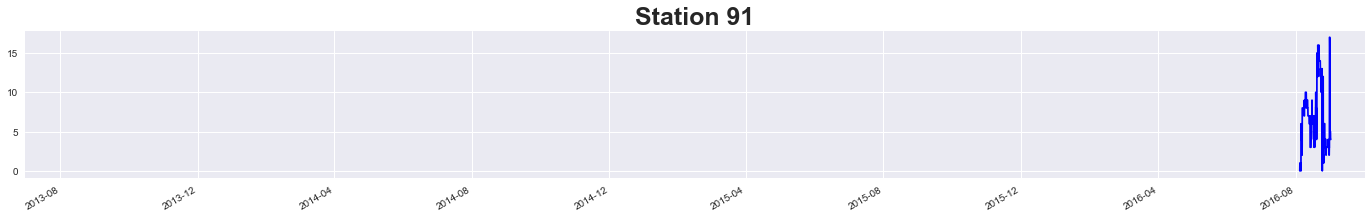

[16:30:53.024396]	Updating 26 to 90 for dates after 2016-08-04 00:00:00
[16:30:53.024647]	Started indexing...
	[16:30:55.926793]	Complete!
[16:30:55.927062]	Started Update...
	[16:31:02.936768]	Complete!


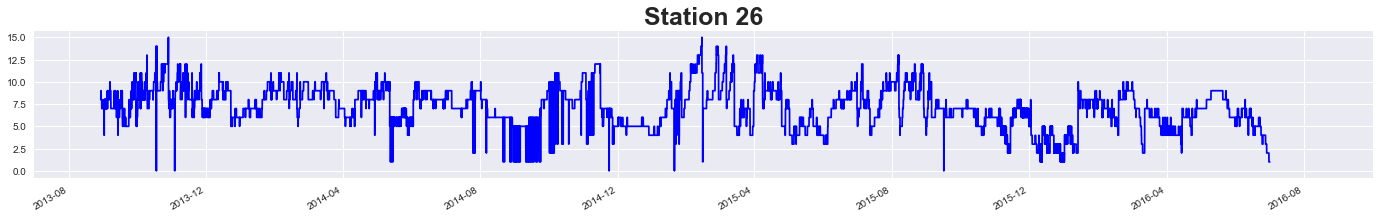

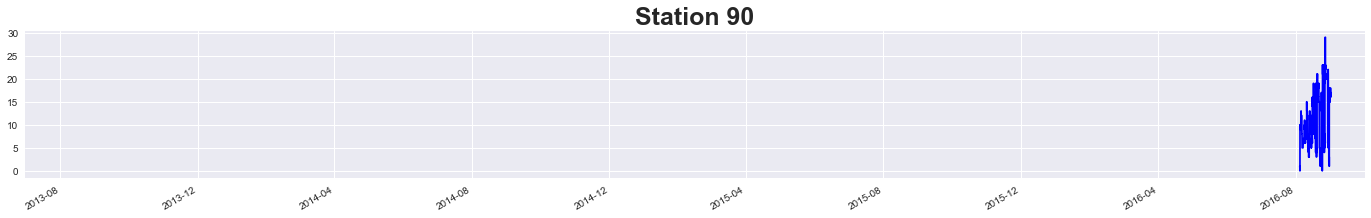

In [16]:
# stations 23 and 24 were relocated on July 5, 2016
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
status_df = date_fixes(df=status_df, old_station=23, new_station=88, change_date=change_date)
status_df = date_fixes(df=status_df, old_station=24, new_station=89, change_date=change_date)

# stations 25 and 26 were relocated on August 4th, 2016
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
status_df = date_fixes(df=status_df, old_station=25, new_station=91, change_date=change_date)
status_df = date_fixes(df=status_df, old_station=26, new_station=90, change_date=change_date)

# Drop station 87, there is no station 87

In [17]:
# drop station 87 - there is no station 87
print('[%s] - Removing Station 87 status, there is no station 87' % (datetime.datetime.now().time()))
print('\t\tremoving %s items' % len(status_df[status_df.station_id == 87].index))
status_df.drop(status_df[status_df.station_id == 87].index, inplace=True)
print('[%s] - Complete' % (datetime.datetime.now().time()))

[16:31:52.534538] - Removing Station 87 status, there is no station 87
		removing 161 items
[16:33:42.562009] - Complete


# Load Station Data

In [18]:
# load Station Data
stations_df = pd.DataFrame()
stations_df = pd.read_csv('./clean_data/station_data_cleaned.csv', index_col=0, parse_dates=['first_service_date', 'last_service_date'])

# drop non necessary columns
stations_df.drop(['days_in_service', 'name', 'lat', 'long', 'first_service_date', 'last_service_date'], axis=1, inplace=True)
stations_df.drop_duplicates(subset=['station_id'], inplace=True)
stations_df.head(3)

,station_id,dock_count,landmark,zip_code
0,2,27,San Jose,95113
1,3,15,San Jose,95113
2,4,11,San Jose,95113


# Merge Status and Station Data

In [19]:
print('[%s] - Starting Merge' % (datetime.datetime.now().time()))
status_df = pd.merge(status_df, stations_df, on='station_id')
print('[%s] - Merge Complete\n' % (datetime.datetime.now().time()))

[16:34:19.345932] - Starting Merge
[16:36:22.265513] - Merge Complete



In [20]:
status_df.head(3)

,station_id,bikes_available,docks_available,time,dock_count,landmark,zip_code
0,2,12,15,2014-03-01 00:00:00,27,San Jose,95113
1,2,12,15,2014-03-01 00:01:00,27,San Jose,95113
2,2,12,15,2014-03-01 00:02:00,27,San Jose,95113


# Downsample Data to 5 Minute Interval Means

In [21]:
print('[%s] Resampling on 5m Interval Mean' % datetime.datetime.now().time())
status_df_5m = status_df.copy()
status_df_5m.set_index(['station_id', 'time'], inplace=True)

# resample on 5 minute interval mean
status_df_5m = status_df_5m.groupby([pd.Grouper(level=0), pd.Grouper(freq='5T', level=-1)]).mean()
status_df_5m.reset_index(inplace=True)

print('\t[%s] Complete!' % datetime.datetime.now().time())

[16:37:01.569732] Resampling on 5m Interval Mean
	[16:45:06.243774] Complete!


# Correct Dock Count on Expanded Station 73
<p>station 73 was expanded from 15 docks to 19 docks on May 19, 2015</p>

In [22]:
change_date = datetime.datetime.strptime('2015-05-19', '%Y-%m-%d')

print('[%s] Correcting Dock Count at Station 73 - Full Dataset' % datetime.datetime.now().time())
change_records = status_df[(status_df.station_id == 73) & (status_df.time > change_date)]
dock_count_col_index = status_df.columns.tolist().index('dock_count')
status_df.iloc[change_records.index,dock_count_col_index] = 19

print('[%s] Correcting Dock Count at Station 73 - Resampled Dataset' % datetime.datetime.now().time())
change_records = status_df[(status_df.station_id == 73) & (status_df.time > change_date)]
dock_count_col_index = status_df.columns.tolist().index('dock_count')
status_df.iloc[change_records.index,dock_count_col_index] = 19

print('\t[%s] Complete!' % datetime.datetime.now().time())

[16:48:01.016178] Correcting Dock Count at Station 73 - Full Dataset
[16:48:16.599754] Correcting Dock Count at Station 73 - Resampled Dataset
	[16:48:20.817492] Complete!


# Calculate Station Utilization
<p>utilization = number of docks available / number of total docks</p>

In [23]:
print('[%s] Calculate Utilization - Full Dataset' % datetime.datetime.now().time())
status_df['utilization'] = status_df['docks_available'] / status_df['dock_count']
status_df['utilization'] = status_df['utilization'].apply(lambda x: 1.0 if x > 1.0 else x)

print('[%s] Calculate Utilization - Resampled Dataset' % datetime.datetime.now().time())
status_df_5m['utilization'] = status_df_5m['docks_available'] / status_df_5m['dock_count']
status_df_5m['utilization'] = status_df_5m['utilization'].apply(lambda x: 1.0 if x > 1.0 else x)
print('\t[%s] Complete!' % datetime.datetime.now().time())

[16:50:02.531925] Calculate Utilization - Full Dataset
[16:51:27.307272] Calculate Utilization - Resampled Dataset
	[16:51:37.715754] Complete!


# Write Data to File - Basic Trip Data

In [24]:
status_df.to_csv('./clean_data/status_data_cleaned.csv', encoding='utf-8')

In [25]:
status_df_5m.to_csv('./clean_data/status_data_5m_resampled_cleaned.csv', encoding='utf-8')

***
# EDA Preview and Quick Reference

In [26]:
status_df.head(3)

,station_id,bikes_available,docks_available,time,dock_count,landmark,zip_code,utilization
0,2,12,15,2014-03-01 00:00:00,27,San Jose,95113,0.555556
1,2,12,15,2014-03-01 00:01:00,27,San Jose,95113,0.555556
2,2,12,15,2014-03-01 00:02:00,27,San Jose,95113,0.555556


In [27]:
status_df_5m.head(3)

,station_id,time,bikes_available,docks_available,dock_count,zip_code,utilization
0,2,2013-08-29 12:05:00,2.0,25.0,27.0,95113.0,0.925926
1,2,2013-08-29 12:10:00,2.0,25.0,27.0,95113.0,0.925926
2,2,2013-08-29 12:15:00,2.0,25.0,27.0,95113.0,0.925926


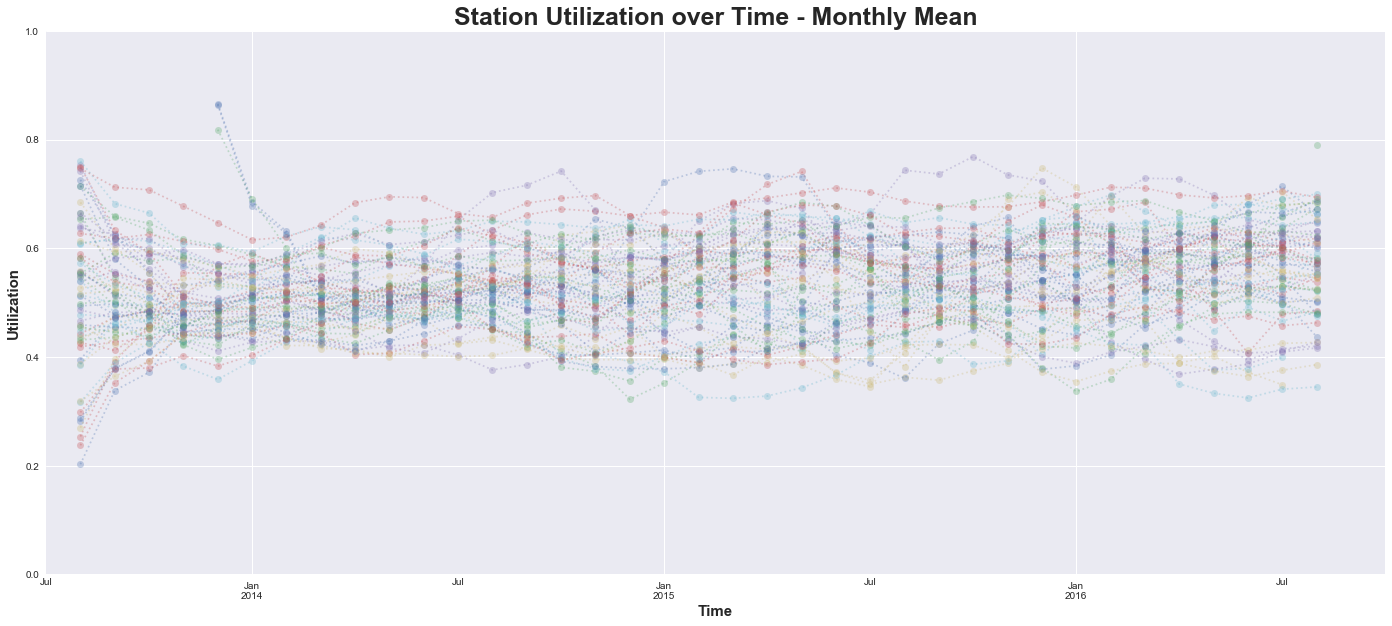

In [34]:
status_df_5m.set_index('time', inplace=True)
for i in sorted(pd.unique(status_df_5m.station_id)):
    tmp = status_df_5m[status_df_5m.station_id == i]
    ax = tmp.utilization.resample('M').mean().fillna(0).rolling(window=3, min_periods=1).mean().plot(linestyle=':', marker='o', alpha=0.3, figsize=(24,10))

time_min = pd.Timestamp('2013-07-01')
time_max = pd.Timestamp('2016-10-01')

ax.set_xlim(time_min, time_max)
ax.set_ylim(0,1)
ax.set_xlabel('Time', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Utilization', size=LABEL_FONT_SIZE, weight='bold')
ax.set_title('Station Utilization over Time - Monthly Mean', size=TITLE_FONT_SIZE, weight='bold')
plt.show()